In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


In [2]:
df = pd.read_csv('log_ap_df.csv').rename(columns={'Unnamed: 0': 'gene'}).set_index('gene')
# tub1 is effed up, so lets kill it
# con1 is effed up, kill it
wanted = [c for c in df.columns if ('tub1' not in c) & ('con1' not in c)]
df = df[wanted]
df = df[(df > 0.5).sum(axis=1) > 5]
df.head()

,con2A,con2P,con4A,con4P,con5A,con5P,tub2A,tub2P,tub3A,tub3P,tub4A,tub4P,tub5A,tub5P
gene,,,,,,,,,,,,,,
SteCoe_1,4.862229,5.083837,5.067023,4.794471,5.159237,4.678247,4.948243,4.704319,4.446902,4.385588,4.280728,4.336849,4.387184,4.150624
SteCoe_10,3.310267,3.557339,3.392957,3.338245,3.079831,3.272346,3.250539,3.426690,3.275349,3.249149,3.441771,3.629246,3.616664,3.561797
SteCoe_100,0.448487,0.950953,0.798218,0.658658,0.697524,0.677687,0.821407,1.071005,1.042232,0.805663,0.996761,0.724791,0.872272,0.880112
SteCoe_1000,3.210635,3.615015,3.176114,3.390179,3.381500,3.083633,3.921269,3.952004,3.869610,4.036804,4.077154,3.725640,3.637402,3.677309
SteCoe_10002,2.642902,3.197424,3.453061,3.314831,3.312158,3.207587,2.994912,3.360969,3.365353,3.120192,3.477802,3.389040,3.553889,3.819785


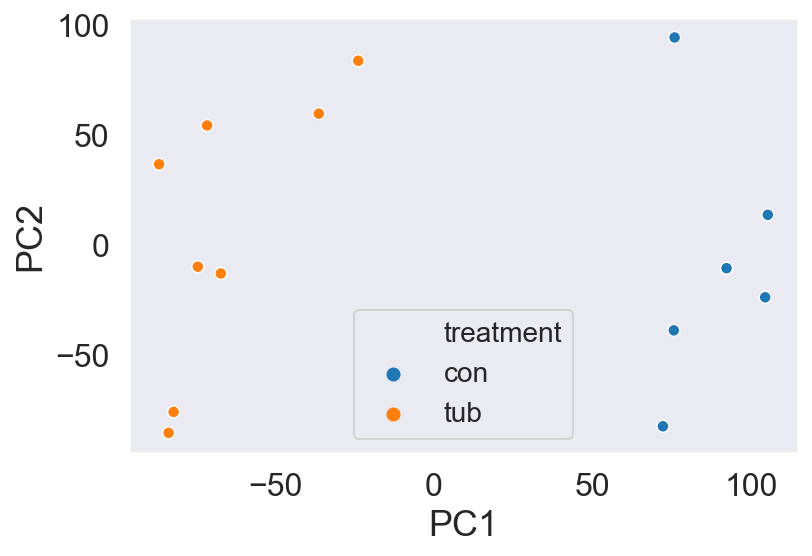

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

# compute a nice pca:
pca = PCA(2)
# SS().fit_transform scales the data so mean per gene is 0, and std per gene = 1
# pca.fit_transform computes pca to 2 components
coords = pca.fit_transform(SS().fit_transform(df.T))
# get coordinates into a nice dataframe
pc = pd.DataFrame(coords, index=df.columns, columns=['PC1', 'PC2'])
# annotate metadata:
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.scatterplot('PC1', 'PC2', hue='treatment', data=pc)

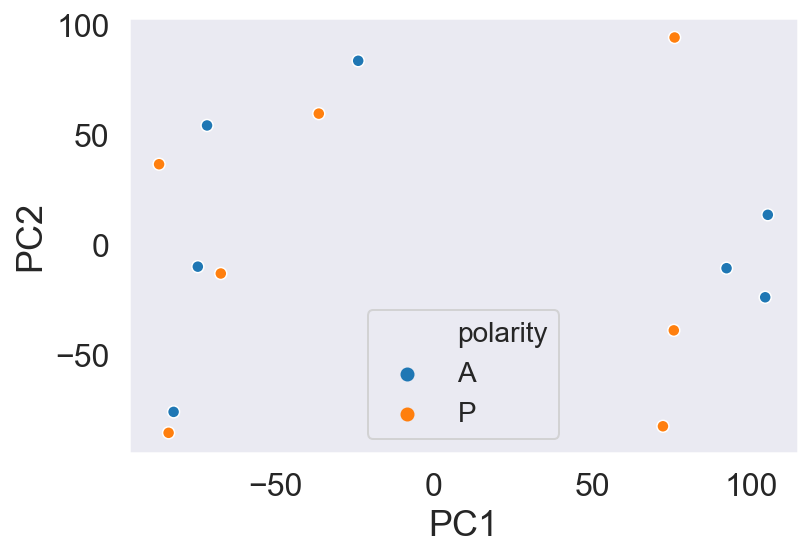

In [7]:
sns.scatterplot('PC1', 'PC2', hue='polarity', data=pc)

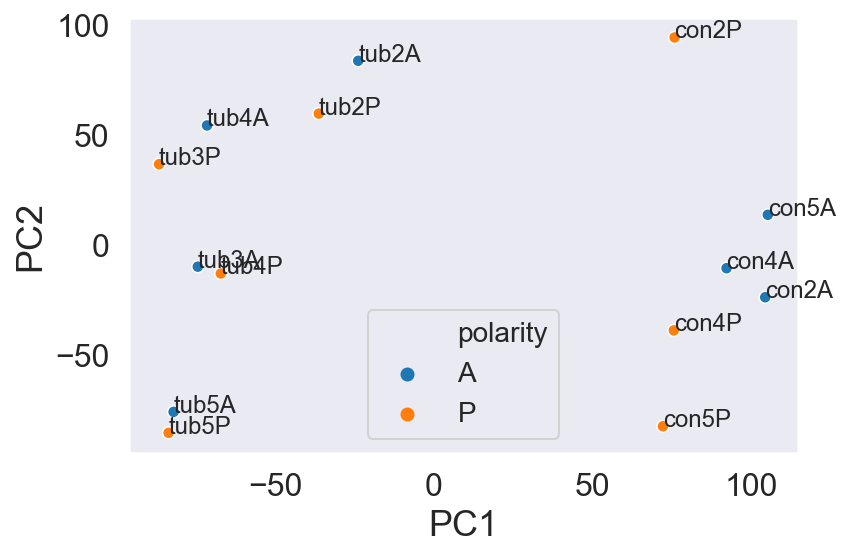

In [8]:
sns.scatterplot('PC1', 'PC2', hue='polarity', data=pc)
for sample in pc.index:
    s = pc.reindex([sample])
    plt.annotate(sample, (s.PC1, s.PC2))

In [9]:
# cast the dataframe from matrix shape into tidy format
tidy = df.reset_index()\
         .melt(id_vars='gene', var_name='Sample', value_name='log1TPM') 
# annotate metadata:
tidy['treatment'] = tidy.Sample.str[:3]
tidy['Cell_ID'] = tidy.Sample.str[:4]
tidy['Polarity'] = tidy.Sample.str[-1]
tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity
0,SteCoe_1,con2A,4.862229,con,con2,A
1,SteCoe_10,con2A,3.310267,con,con2,A
2,SteCoe_100,con2A,0.448487,con,con2,A
3,SteCoe_1000,con2A,3.210635,con,con2,A
4,SteCoe_10002,con2A,2.642902,con,con2,A


In [10]:
# compute mean log1TPM per sample
tidy['sample_mean_log1TPM'] = tidy.groupby('Sample').log1TPM.transform(np.mean).values
# compute a "regularized" log1TPM, which is equal to log1TPM + mean log1TPM for that sample
tidy['log1RPM'] = tidy.log1TPM + tidy.sample_mean_log1TPM
tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity,sample_mean_log1TPM,log1RPM
0,SteCoe_1,con2A,4.862229,con,con2,A,2.046958,6.909187
1,SteCoe_10,con2A,3.310267,con,con2,A,2.046958,5.357225
2,SteCoe_100,con2A,0.448487,con,con2,A,2.046958,2.495445
3,SteCoe_1000,con2A,3.210635,con,con2,A,2.046958,5.257593
4,SteCoe_10002,con2A,2.642902,con,con2,A,2.046958,4.689860


In [12]:
# split tidy dataframe into two, A and P dataframes
atidy = tidy[tidy.Polarity == 'A'].set_index(['gene', 'Cell_ID'])
ptidy = tidy[tidy.Polarity == 'P'].set_index(['gene', 'Cell_ID'])

# stack the two tidy dataframes so that A and P from the same cell are side by side
stack = atidy.join(ptidy[['log1RPM', 'sample_mean_log1TPM']], rsuffix=('_posterior'))
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior
gene,Cell_ID,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242


In [14]:
# compute skew as regularized Delta / regularized Total counts
stack['Skew'] = ((stack.log1RPM - stack.log1RPM_posterior) /
                 (stack.log1RPM + stack.log1RPM_posterior))
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew
gene,Cell_ID,,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242,-0.020958
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242,-0.088528
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242,-0.035468
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242,-0.054133


<ipython-input-15-b5b912c410bb>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_skews = stack.reset_index()\


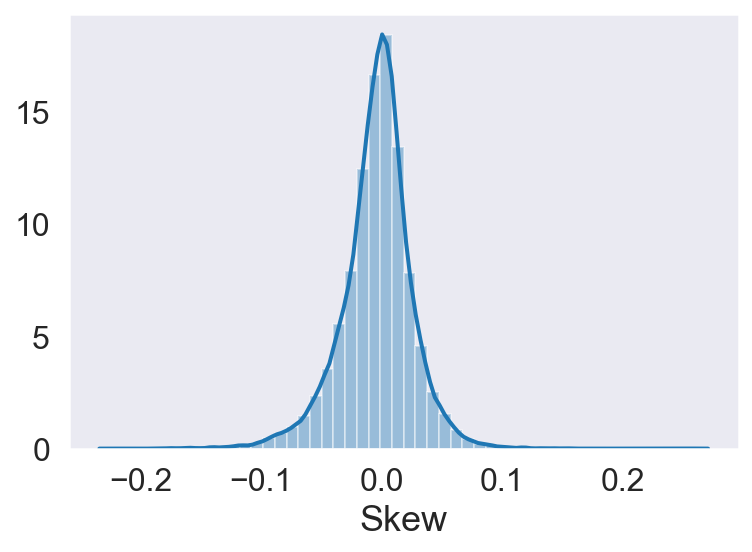

In [15]:
# visualize a histogram of mean skews.
mean_skews = stack.reset_index()\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()

mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2
sns.distplot(mean_skews[mean_skews.treatment == 'con'].Skew)

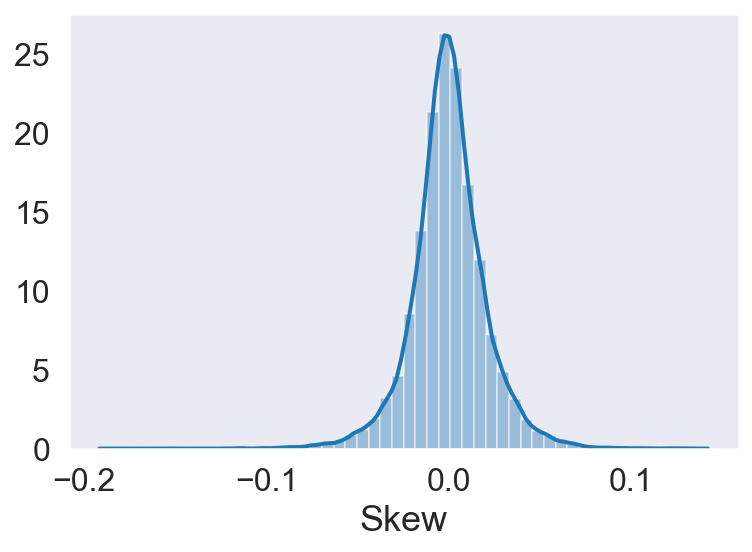

In [16]:
sns.distplot(mean_skews[mean_skews.treatment == 'tub'].Skew)

Text(0.5, 1.0, 'Skew')

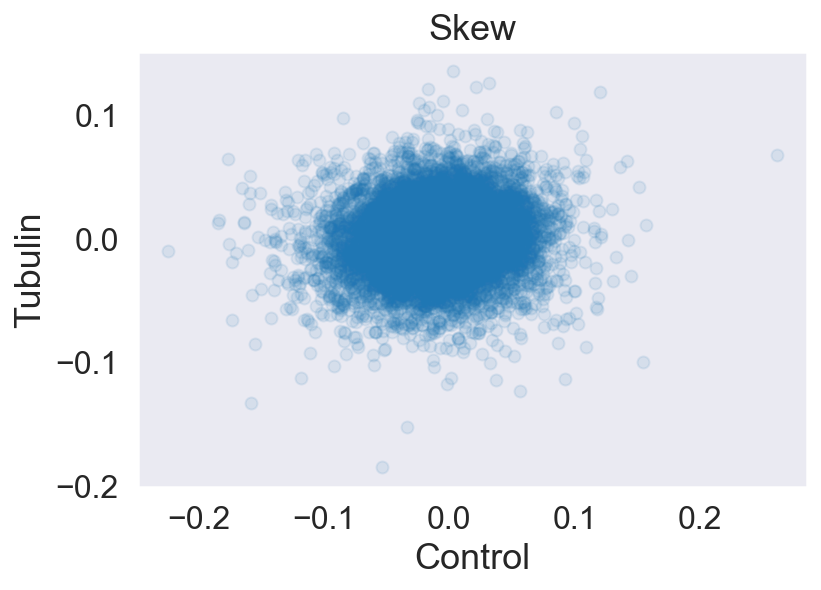

In [17]:
# plot mean skews in control vs tubulin
cond = lambda x: mean_skews.treatment == x
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha=0.1)

plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.title('Skew')

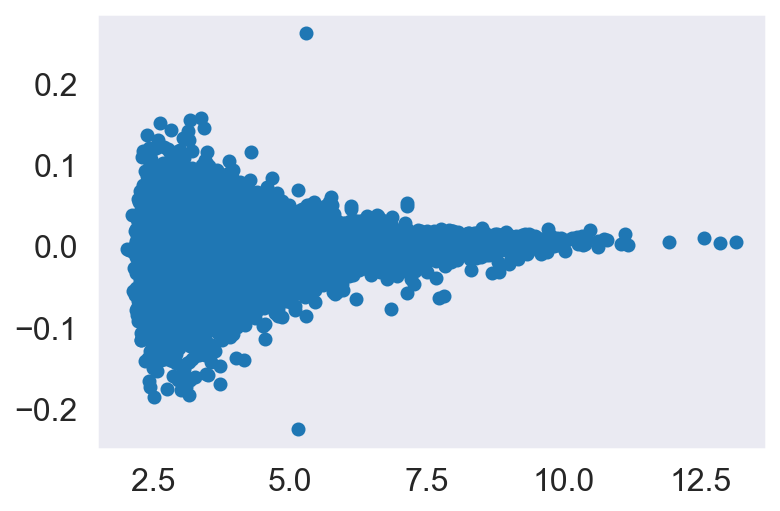

In [18]:
# mean vs skew plots
plt.scatter(mean_skews[cond('con')].mean_log1RPM, mean_skews[cond('con')].Skew)

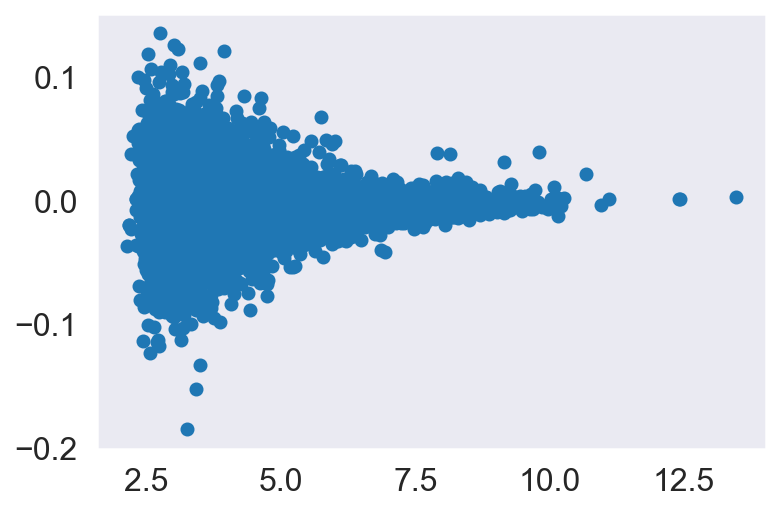

In [19]:
plt.scatter(mean_skews[cond('tub')].mean_log1RPM, mean_skews[cond('tub')].Skew)

In [20]:
import scipy
from statsmodels.stats.multitest import fdrcorrection


25322


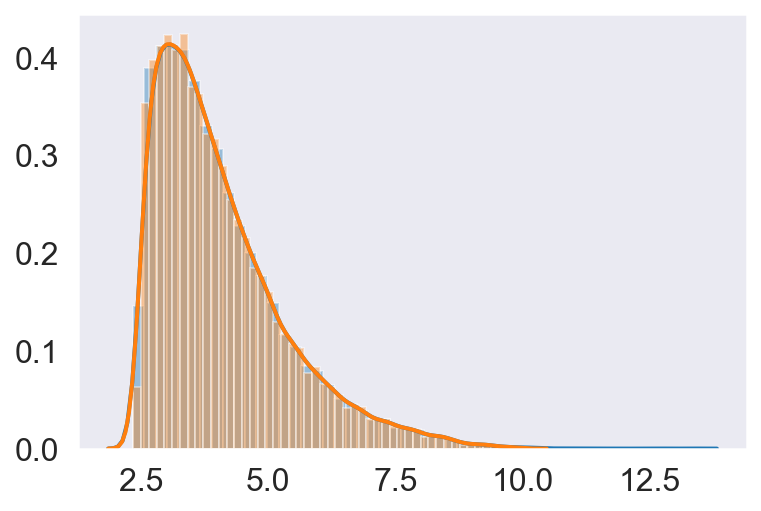

In [21]:
# make sure RPMs are within a reasonable range:
mean_rpm = stack.groupby('gene')[['log1RPM_posterior', 'log1RPM']].mean().mean(axis=1)
wanted = mean_rpm[mean_rpm.between(2, 10)].index
print(len(wanted))
sns.distplot(mean_rpm)
sns.distplot(mean_rpm[mean_rpm.between(2, 10)])

In [22]:
# compute a fano factor (std / mean) so we don't test things that are
# so variable that they would never be stat sig differentially expressed
# therefore reducing our FDR penalty
stack = stack.reset_index()[stack.reset_index().gene.isin(wanted)]
stack['fano_factor'] = stack.groupby(['gene', 'treatment']).Skew\
                            .transform(lambda x: np.std(x) / np.abs(np.mean(x)))
stack.sort_values(['gene', 'Cell_ID'], inplace=True)
stack.head()

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,fano_factor
0,SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541,1.618032
25339,SteCoe_1,con4,con4A,5.067023,con,A,2.005359,7.072382,6.803104,2.008634,0.019407,1.618032
50678,SteCoe_1,con5,con5A,5.159237,con,A,2.006640,7.165877,6.736237,2.057990,0.030905,1.618032
76017,SteCoe_1,tub2,tub2A,4.948243,tub,A,2.050640,6.998883,6.747187,2.042867,0.018310,1.051115
101356,SteCoe_1,tub3,tub3A,4.446902,tub,A,2.052930,6.499831,6.437725,2.052137,0.004800,1.051115


In [24]:
# remove genes where the fano factor is >2. 
stack = stack[stack.fano_factor < 2]
# find genes that are present in tub and control, cause the above line may have broken that
sel = (stack.groupby('gene').treatment.count() == 7)
wanted = stack.groupby('gene').treatment.count()[sel].index
stack = stack[stack.gene.isin(wanted)]

In [46]:
len(stack.gene.unique())

5853

In [26]:
# do a t-test for statistical significance
PV = []
G = []
for gene, group in stack.reset_index()[stack.reset_index().gene.isin(wanted)].groupby('gene'):
    npolar = group[group.treatment == 'tub'].Skew
    polar = group[group.treatment == 'con'].Skew
    t, p = scipy.stats.ttest_ind(npolar, polar, equal_var=False)
    PV += [p]
    G += [gene]
    
# store results in a dataframe:
pvals = pd.DataFrame([PV, G], index=['p_value', 'gene']).T.set_index('gene')
pvals['q_value'] = fdrcorrection(pvals.p_value.values)[1]
pvals['sig'] = (pvals.sort_values('q_value').q_value < 0.1).values
pvals.head()

,p_value,q_value,sig
gene,,,
SteCoe_1,0.85969,0.972325,False
SteCoe_10,0.572064,0.867843,False
SteCoe_10009,0.11092,0.529262,False
SteCoe_10020,0.111068,0.529262,False
SteCoe_10021,0.0497096,0.529262,False


In [47]:
pvals.sort_values('p_value')

,p_value,q_value,sig
gene,,,
SteCoe_27397,0.000112595,0.278436,False
SteCoe_24733,0.000127639,0.278436,False
SteCoe_33586,0.000153672,0.278436,False
SteCoe_20522,0.000190286,0.278436,False
SteCoe_2417,0.000325698,0.381262,False
...,...,...,...
SteCoe_30898,0.997808,0.99836,False
SteCoe_21045,0.997848,0.99836,False
SteCoe_33282,0.998188,0.99853,False


In [28]:
# number of DE genes at alpha < 0.1
pvals.sig.sum()

0

In [38]:
# append results to our master "stack" dataframe:
stack = stack.join(pvals, on='gene')

<ipython-input-141-4c6d17a44344>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_skews = stack\


Text(0.5, 1.0, 'Skew')

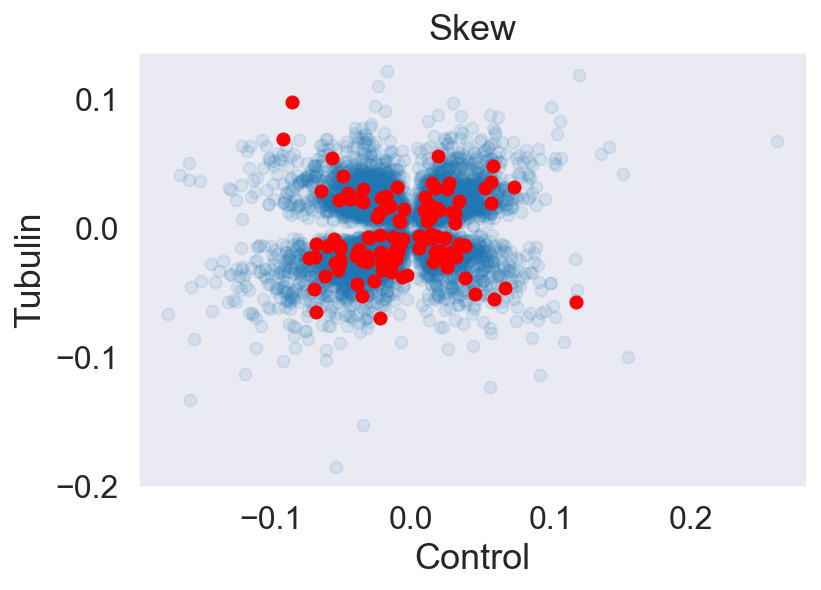

In [141]:
# recompute mean skews
mean_skews = stack\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()
mean_skews = mean_skews.join(pvals.sig, on='gene')

cond = lambda x: (mean_skews.treatment == x)
mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2


# plot tubulin vs control skews. Now the plot will not look like an oval,
# mainly because we removed lots of things that were low expression, or that had
# poor fano factors
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha=0.1)
plt.scatter(mean_skews[cond('con') & (mean_skews.sig == True)].Skew,
            mean_skews[cond('tub') & (mean_skews.sig == True)].Skew, color='red')
plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.title('Skew')

# the plot below looks like a butterfly
# the correlated arm are likely genes where the KD did not have
# a strong effect on rna localization
# the anticorrelated arm are genes that switched their localization
# upon KD of tubulin

In [154]:
# most interesting genes are likely anticorrelated
# switch the mean_skews matrix from tidy format into matrix format,
# where genes are rows, and there are two columns, control and treatment
skew_mat = mean_skews.pivot(index='gene', columns='treatment', values='Skew')
# select things that are anticorrelated
#(anticorrelated genes have opposing signs) in tubulin and control
anticorr = skew_mat[skew_mat.con * skew_mat.tub < 0].index

# select anticorrelated genes between tub and control, that are sig in qval
# and for tidyness select just controls
select = ((mean_skews.gene.isin(anticorr)) &
          (mean_skews.sig) &
          (mean_skews.treatment == 'con'))
        
mean_skews[select].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM
8,con,SteCoe_10036,2.229674,2.676440,-0.091622,True,2.453057
180,con,SteCoe_11137,2.342291,2.777888,-0.085025,True,2.560090
50,con,SteCoe_1033,2.343970,2.655655,-0.064580,True,2.499813
45,con,SteCoe_10317,2.691425,3.003394,-0.056639,True,2.847410
3,con,SteCoe_10020,3.865211,4.268423,-0.051572,True,4.066817
140,con,SteCoe_10847,2.193770,2.435343,-0.048324,True,2.314557
124,con,SteCoe_10767,2.579275,2.822901,-0.045184,True,2.701088
109,con,SteCoe_10675,3.221205,3.512991,-0.043617,True,3.367098
159,con,SteCoe_10965,3.233901,3.485096,-0.037980,True,3.359499
151,con,SteCoe_10900,3.105436,3.322309,-0.034272,True,3.213873


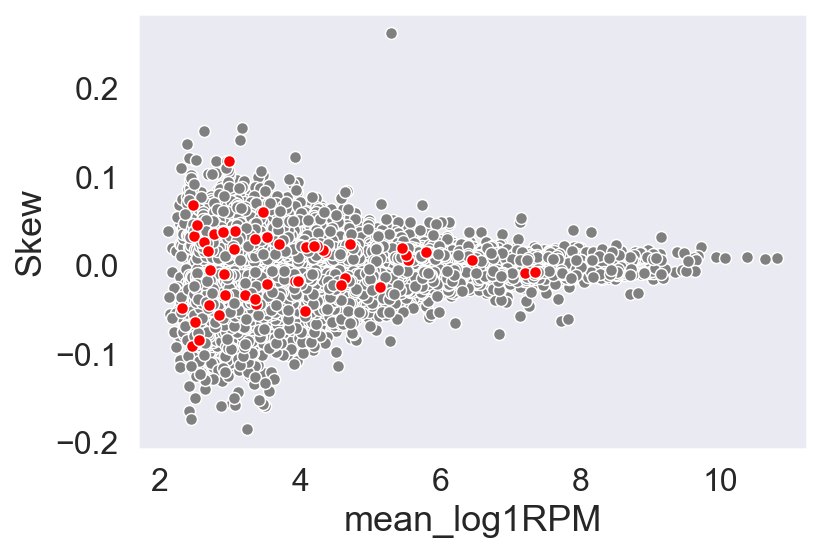

In [156]:
# MA plot showing how low or high regularized expression these genes have:
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews, color='gray')
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews[select], color='red')


In [162]:
# compute the transcriptome wide skew per sample:
avg_skew = ((stack.sample_mean_log1TPM - stack.sample_mean_log1TPM_posterior) /
            (stack.sample_mean_log1TPM + stack.sample_mean_log1TPM_posterior))
stack['avg_skew_treatment'] = avg_skew

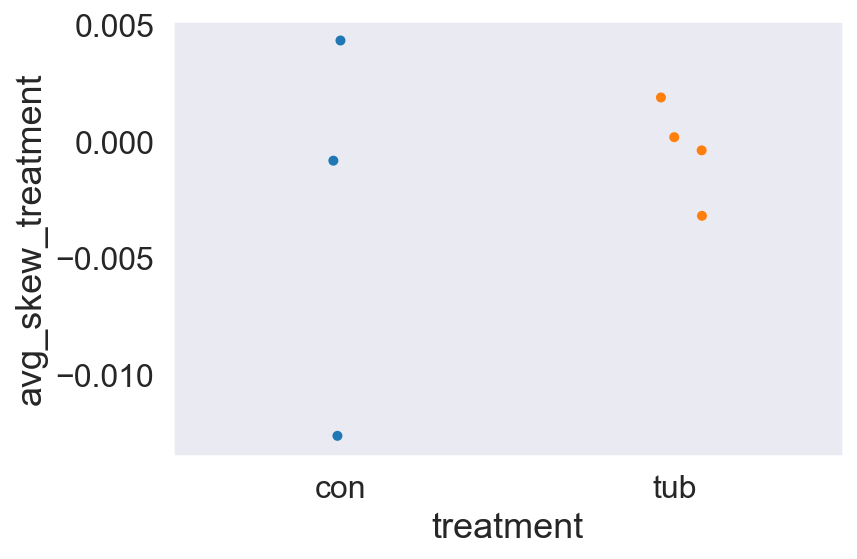

In [166]:
# for each sample, plot the transcriptome-wide skew:
sns.stripplot('treatment', 'avg_skew_treatment',
              data=stack[['treatment', 'avg_skew_treatment']].drop_duplicates())

In [175]:
# compute the mean transcriptome-wide skews for control and tubulin
# and then compute the difference of means between both conditions
# this is the smallest believable "skew"
stack[['treatment', 'avg_skew_treatment']]\
    .drop_duplicates()\
    .groupby('treatment')\
    .mean()\
    .diff()\
    .dropna()

,avg_skew_treatment
treatment,
tub,0.002668


In [169]:
# the above line tells you what difference is probably the smallest difference
# you should ever believe in skew

In [174]:
# all samples have Skews > 0.0027, but let's make sure anyways
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM
8,con,SteCoe_10036,2.229674,2.676440,-0.091622,True,2.453057
180,con,SteCoe_11137,2.342291,2.777888,-0.085025,True,2.560090
50,con,SteCoe_1033,2.343970,2.655655,-0.064580,True,2.499813
45,con,SteCoe_10317,2.691425,3.003394,-0.056639,True,2.847410
3,con,SteCoe_10020,3.865211,4.268423,-0.051572,True,4.066817
140,con,SteCoe_10847,2.193770,2.435343,-0.048324,True,2.314557
124,con,SteCoe_10767,2.579275,2.822901,-0.045184,True,2.701088
109,con,SteCoe_10675,3.221205,3.512991,-0.043617,True,3.367098
159,con,SteCoe_10965,3.233901,3.485096,-0.037980,True,3.359499
151,con,SteCoe_10900,3.105436,3.322309,-0.034272,True,3.213873


In [193]:
x = []
y = []
with open('S_coeruleus_Nov2017_proteins.fasta') as f:
    lines = f.readlines()
    for l in lines:
        if '>' in l:
            line = l.split('\t')
            gene = line[0][1:]
            domain = line[1].strip()
            x += [gene]
            y += [domain]

prot_data = pd.DataFrame([x, y], index=['gene', 'domain']).T.set_index('gene')

In [199]:
mean_skews = mean_skews.join(prot_data, on='gene')

In [200]:
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
8,con,SteCoe_10036,2.229674,2.676440,-0.091622,True,2.453057,CK1 kinase
180,con,SteCoe_11137,2.342291,2.777888,-0.085025,True,2.560090,hypothetical protein
50,con,SteCoe_1033,2.343970,2.655655,-0.064580,True,2.499813,RabGAP-TBC domain protein
45,con,SteCoe_10317,2.691425,3.003394,-0.056639,True,2.847410,CK2 family kinase
3,con,SteCoe_10020,3.865211,4.268423,-0.051572,True,4.066817,Metallophos domain protein
140,con,SteCoe_10847,2.193770,2.435343,-0.048324,True,2.314557,Ras domain protein
124,con,SteCoe_10767,2.579275,2.822901,-0.045184,True,2.701088,Amidohydro_1 domain protein
109,con,SteCoe_10675,3.221205,3.512991,-0.043617,True,3.367098,CS domain protein
159,con,SteCoe_10965,3.233901,3.485096,-0.037980,True,3.359499,HECT domain protein
151,con,SteCoe_10900,3.105436,3.322309,-0.034272,True,3.213873,PKG family kinase
